# Vessel Manoeuvring Models
Many simulation model for ship manoeuvring have been developed in the field of ship hydrodynamics such as: the Abkowitz model {cite:p}`abkowitz_ship_1964` or the Norrbin model {cite:p}`norrbin_study_1960`.
This chapter will develop a general simulation model for ship manoeuvring, that can be further specified to become either the Abkowitz or Norbin model. Expressing the models on a general form is important in this research where many different models will be tested and compared.

In [1]:
# %load imports.py
%load_ext autoreload
%autoreload 2
%reload_kedro
%config Completer.use_jedi = False  ## (To fix autocomplete)

import pandas as pd
from src.models.vmm import ModelSimulator
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams["figure.figsize"] = (10,10)
plt.style.use('presentation')
from src.visualization.plot import track_plots, plot, captive_plot
import kedro
import numpy as np
import os.path
import anyconfig


from myst_nb import glue
from src.symbols import *
import src.symbols as symbols
from src.system_equations import *

from IPython.display import display, Math, Latex, Markdown
from sympy.physics.vector.printing import vpprint, vlatex

from src.models.regression import MotionRegression

from src.parameters import df_parameters
p = df_parameters["symbol"]

# Read configs:
conf_path = os.path.join("../../conf/base/")
runs_globals_path = os.path.join(
    conf_path,
    "runs_globals.yml",
)

runs_globals = anyconfig.load(runs_globals_path)
model_test_ids = runs_globals["model_test_ids"]

join_globals_path = os.path.join(
    conf_path,
    "join_globals.yml",
)

joins = runs_globals["joins"]
join_runs_dict = anyconfig.load(join_globals_path)

globals_path = os.path.join(
    conf_path,
    "globals.yml",
)
global_variables = anyconfig.load(globals_path)



vmm_names = global_variables["vmms"]
only_joined = global_variables[
    "only_joined"
]  # (regress/predict with only models from joined runs)S

vmms = {}
for vmm_name in vmm_names:
    vmms[vmm_name] = catalog.load(vmm_name)


UsageError: Line magic function `%reload_kedro` not found.


3DOF system for manoeurving:

In [2]:
eq_system

Eq(Matrix([
[-X_{\dot{u}} + m,                    0,                    0],
[               0,     -Y_{\dot{v}} + m, -Y_{\dot{r}} + m*x_G],
[               0, -N_{\dot{v}} + m*x_G,    I_z - N_{\dot{r}}]])*Matrix([
[\dot{u}],
[\dot{v}],
[\dot{r}]]), Matrix([
[m*r**2*x_G + m*r*v + X_D(u, v, r, delta, thrust)],
[            -m*r*u + Y_D(u, v, r, delta, thrust)],
[        -m*r*u*x_G + N_D(u, v, r, delta, thrust)]]))

The manoeuvring simulation can now be conducted by numerical integration of the above equation. The main difference between various vessel manoeuvring models such as the Abkowitz model {cite:p}`abkowitz_ship_1964` or the Norrbin model {cite:p}`norrbin_study_1960` lies in how the hydrodynamic functions $X_D(u,v,r,\delta,thrust)$, $Y_D(u,v,r,\delta,thrust)$, $N_D(u,v,r,\delta,thrust)$ are defined. These functions cane be found in [Appendix](appendix_vmms.md).

Note that a coefficient $X_{thrust}$ has been added to the Abkowitz X equation to allow for propeller thrust as an input to the model. 

In [3]:
vmms['vmm_abkowitz'].Y_qs_eq

Eq(Y_D(u, v, r, delta, thrust), Y_{0uu}*u**2 + Y_{0u}*u + Y_{0} + Y_{deltadeltadelta}*delta**3 + Y_{delta}*delta + Y_{rdeltadelta}*delta**2*r + Y_{rrdelta}*delta*r**2 + Y_{rrr}*r**3 + Y_{r}*r + Y_{udelta}*delta*u + Y_{ur}*r*u + Y_{uudelta}*delta*u**2 + Y_{uur}*r*u**2 + Y_{uuv}*u**2*v + Y_{uv}*u*v + Y_{vdeltadelta}*delta**2*v + Y_{vrdelta}*delta*r*v + Y_{vrr}*r**2*v + Y_{vvdelta}*delta*v**2 + Y_{vvr}*r*v**2 + Y_{vvv}*v**3 + Y_{v}*v)

In [4]:
vmms['vmm_linear'].Y_qs_eq

Eq(Y_D(u, v, r, delta, thrust), Y_{delta}*delta + Y_{r}*r + Y_{u}*u + Y_{v}*v)

This equation can be rewritten to get the acceleration on the left hand side:

In [5]:
eq_acceleration_matrix_clean

Eq(Eq(\dot{\nu}, Matrix([
[\dot{u}],
[\dot{v}],
[\dot{r}]])), Matrix([
[1/(-X_{\dot{u}} + m),                         0,                         0],
[                   0,   -(-I_z + N_{\dot{r}})/S, -(-Y_{\dot{r}} + m*x_G)/S],
[                   0, -(-N_{\dot{v}} + m*x_G)/S,      -(Y_{\dot{v}} - m)/S]])*Matrix([
[m*r**2*x_G + m*r*v + X_D(u, v, r, delta, thrust)],
[            -m*r*u + Y_D(u, v, r, delta, thrust)],
[        -m*r*u*x_G + N_D(u, v, r, delta, thrust)]]))

where $S$ is a helper variable:

In [6]:
eq_S

Eq(S, -I_z*Y_{\dot{v}} + I_z*m + N_{\dot{r}}*Y_{\dot{v}} - N_{\dot{r}}*m - N_{\dot{v}}*Y_{\dot{r}} + N_{\dot{v}}*m*x_G + Y_{\dot{r}}*m*x_G - m**2*x_G**2)

A state space model for manoeuvring can now be defined with six states:

In [7]:
eq_x

Eq(\vec{x}, Matrix([
[ x_0],
[ y_0],
[\Psi],
[   u],
[   v],
[   r]]))

An transition function $f$ defines how the states changes with time:

In [8]:
eq_state_space

Eq(\dot{\vec{x}}, f(\vec{x}, u_{input}, w_{noise}))

Using geometrical relations for how $x_0$, $y_0$ and $\Psi$ depend on $u$, $v$, and $r$ and the time derivatives that was derived above: $\dot{u}$, $\dot{v}$, $\dot{r}$, the transition function can be written:

In [9]:
eq_f

Eq(f(\vec{x}, u_{input}, w_{noise}), Matrix([
[u*cos(\Psi) - v*sin(\Psi)],
[u*sin(\Psi) + v*cos(\Psi)],
[                        r],
[                  \dot{u}],
[                  \dot{v}],
[                  \dot{r}]]))

In [10]:
vmm_name = 'vmm_martins_simple'
ek = catalog.load(f"{ vmm_name }.ek")
model = catalog.load(f"{ vmm_name}.motion_regression.joined.model")
vmm = catalog.load(f"{ vmm_name }")
ek.parameters = model.parameters
added_masses = catalog.load("added_masses")

2022-03-24 21:08:11,932 - kedro.io.data_catalog - INFO - Loading data from `vmm_martins_simple.ek` (ExtendedKalmanDataSet)...
2022-03-24 21:08:11,937 - kedro.io.data_catalog - INFO - Loading data from `vmm_martins_simple.motion_regression.joined.model` (PickleDataSet)...
2022-03-24 21:08:11,944 - kedro.io.data_catalog - INFO - Loading data from `vmm_martins_simple` (PickleDataSet)...
2022-03-24 21:08:11,948 - kedro.io.data_catalog - INFO - Loading data from `added_masses` (YAMLDataSet)...


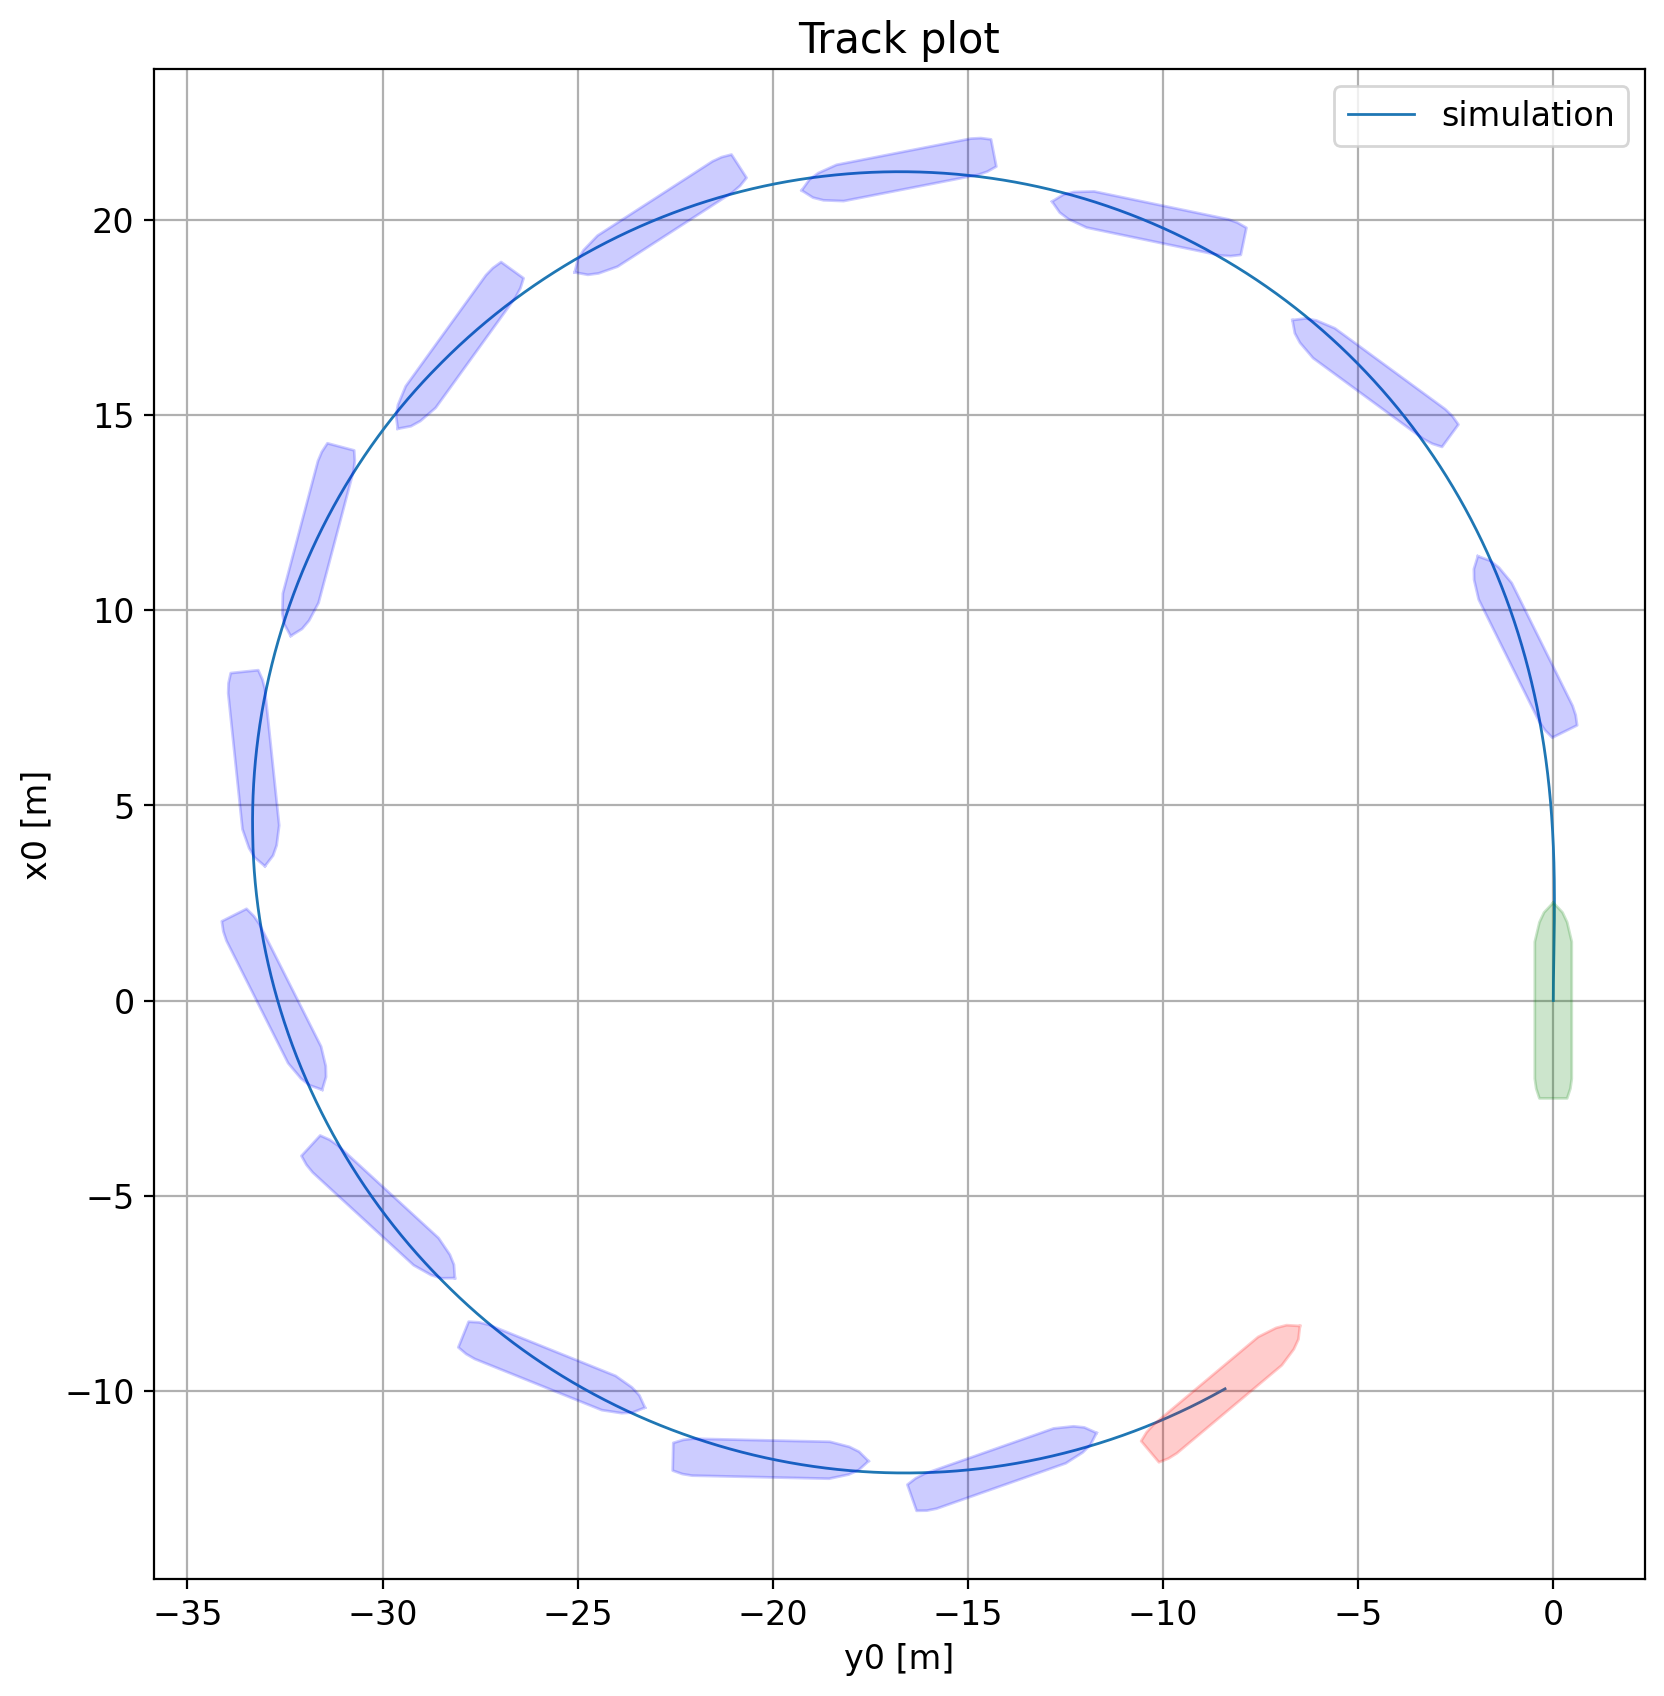

In [11]:
t = np.arange(0, 70, 0.01)
input_columns = ['delta','U','thrust']
state_columns = ['x0', 'y0', 'psi', 'u', 'v', 'r']
data = pd.DataFrame(index=t, columns=state_columns + input_columns)
data['u'] = 2
data['delta'] = np.deg2rad(15)
data['thrust'] = 30
data.fillna(0, inplace=True)
data['U'] = np.sqrt(data['u']**2 + data['v']**2)


result = model.simulate(df_=data)

dataframes = {'simulation': result.result}
#dataframes['simulate'] = ek.simulate(data=data, input_columns=input_columns, solver='Radau')
track_plots(dataframes, lpp=model.ship_parameters['L'], beam=model.ship_parameters['B'], N=15, 
            styles={'simulation':{'alpha':1}});
result.result.to_csv('example.csv')